In [1]:
!python --version

Python 3.8.6


### TODO

* ~Try a built-in optimizer (like grad descent w/ momentum) instead of constant learning rate. See how convergence time changes~
* ~Plot loss~
* ~Refactor (processors are modules)~
* ~Define `init_params` methods for each processor, initializing to params that have no effect on the signal (no-op  prior)~
  - this is something to note in writeup. talk about small changes to params having big effect in processors with feedback. And how starting from no effect initially is good for live performance settings.
* ~Add a simple clipping nonlinearity effect to see how `grad` does with that~
* ~Refactoring~
  - ~Use dicts for labeled params instead of n-d arrays (jax handles this)~
  - ~Move parameter label creation into processor fns~
* ~Estimate params for multiple serially-connected filters (create a general `serial_processors` processor)~
* ~~Run on GPU & measure performance differences~~
  - Performance is indeed much better on a GPU, despite the serial bottlneck of the IIR filters.
  - E.g. for a length-5 IIR filter with an input sequence of length 300, on a GPU:
    `CPU times: user 14.6 s, sys: 664 ms, total: 15.3 s, Wall time: 15.7 s`.
    On the CPU, it wouldn't even finish for more than 5 minutes so I stopped it and dropped the input length to 100, and got these numbers; `CPU times: user 37.1 s, sys: 816 ms, total: 38 s, Wall time: 37.7 s`
* Add `processArray` methods to all processors, which will allow for fast convolution FIR implementations
* Add a `DelayLine` processor. This is fundamentally a FIR filter, with the important difference that it's only parameterized by a couple params (like delay length and dry/wet level), rather than one param for each coefficient. The single-sample `tick` method can show off the ability to implement in the more traditional read/write pointer style as well.
* Add `AllpassFilter` and `CombFilter` processors
* How to speed up IIR filters (like allpass filters)?
  - What if we estimate parameters without running across the full input sample? Like just test against a very small input sample? E.g. a length-5 IIR filter shouldn't need to backprop against every sample of a 2-second clip. That's just super redundant, right? Its behavior should be fully determinable from an input sample of a length on the order of the coefficients I think. This could generalize to other processors as well. (Maybe something like a `testLength` for each processor.) Should be able to test this well by comparing loss as `testLength` drops.
* Test on a realistic 4-second audio signal at 24kHz
* Animate changes in output signal over time, compared with target
* Try batches of short sample pairs (more than just single unit impulse signal) and see if it finds parameters closer to ground truth. Also, chart number of batches to some loss vs number of training pairs per batch.
  - If multiple training pairs would help gradient descent for this problem, then we could do training batches in parallel. I’m not sure if this is necessary for the LTI case, since a single unit impulse input should fully determine the output behavior for arbitrary inputs. But maybe seeing more diverse pairs would help find better gradient estimates in general? At the very least, fewer total batches should be needed to achieve the same loss as batch size increases, so training should speed up if we can train multiple streams in parallel per-batch.
* Use a perceptual loss function instead of mse (steal DDSP's multi-scale spectral loss fn)
* Improve performance
  - ~Speed things up with [JIT](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Using-jit-to-speed-up-functions)~
* ~I don't think functions truly need to be pure. I tried passing in a plain np array and changing it in place and it seemed to work fine. Maybe we can use shared buffers to improve memory usage?~
  - Answer - this is because you can create and use state _inside_ functions transformed by JAX. I found a decent middleground here that lets me use processor classes with internal state by instantiating them inside the transformed fn.
* End-goal (ready for blog post): [Implement freeverb and perform dereverbing](https://trello.com/c/NSnb806w/2-goal-parameterize-freeverb)

In [2]:
import jax.numpy as jnp
from scipy import signal
import numpy as np

In [3]:
import sys
sys.path.append('./')
sys.path.append('./processors')
from fir_filter import FirFilter
from iir_filter import IirFilter
from clip import Clip
from plotters import plot_filter, plot_loss, plot_params
from train import train, train_serial

In [4]:
%%time
X = jnp.concatenate([jnp.array([1.0]), jnp.zeros(100)])
    
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train(FirFilter, X)

CPU times: user 1.58 s, sys: 118 ms, total: 1.7 s
Wall time: 1.57 s


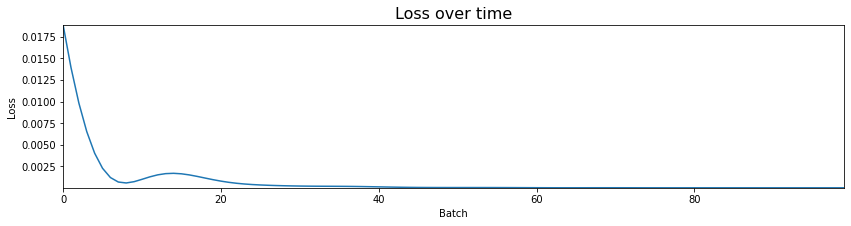

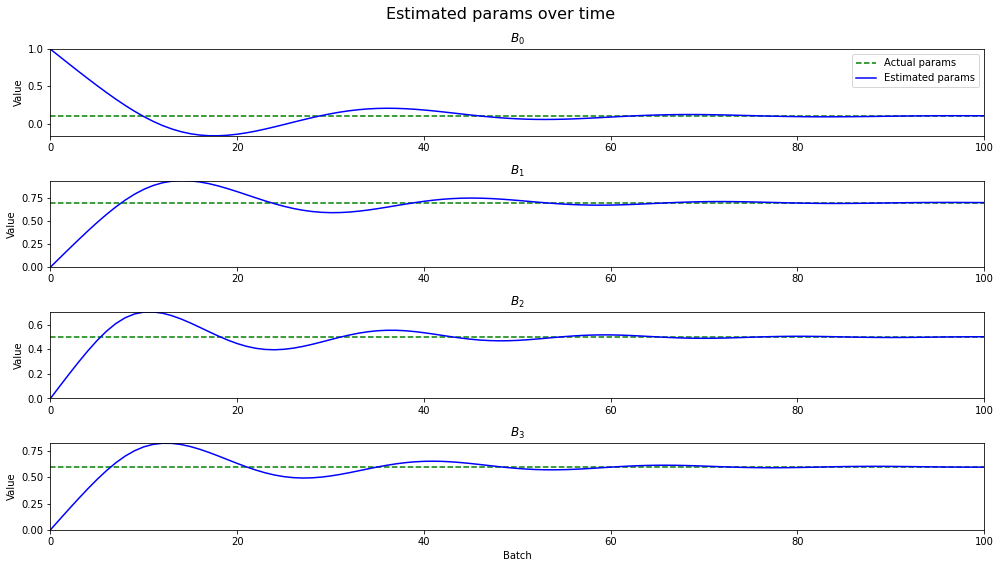

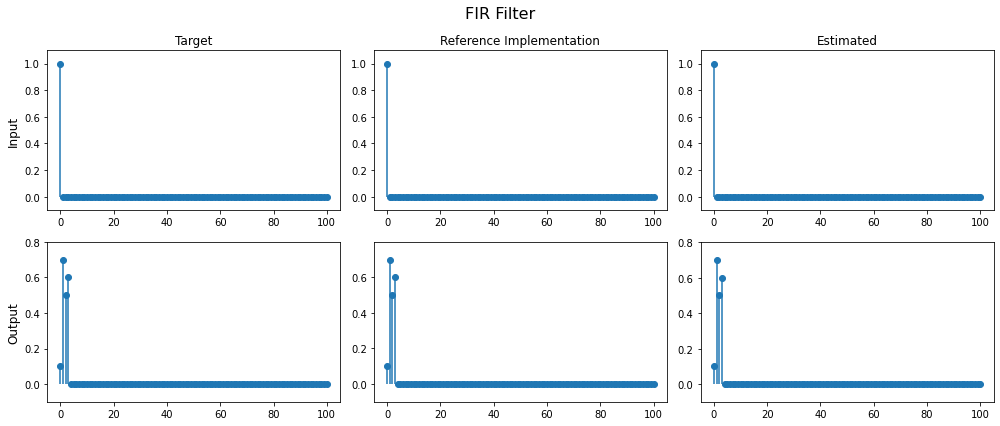

In [5]:
plot_loss(loss_history)
plot_params(params_target, params_history)
Y_reference = signal.lfilter(params_target['B'], [1.0], X)
plot_filter(X, Y_target, Y_reference, Y_estimated, 'FIR Filter')

In [6]:
%%time
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train(IirFilter, X)

CPU times: user 37.1 s, sys: 816 ms, total: 38 s
Wall time: 37.7 s


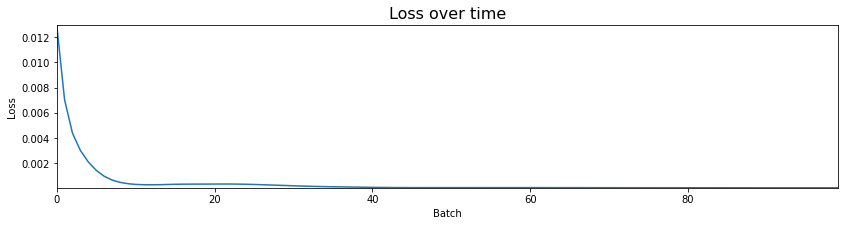

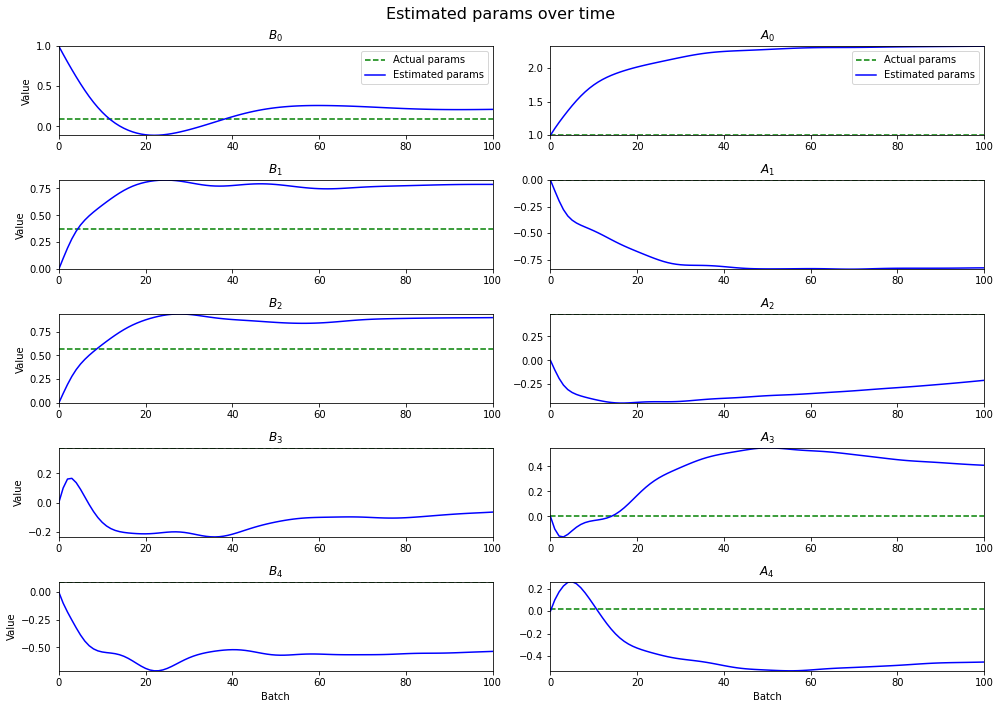

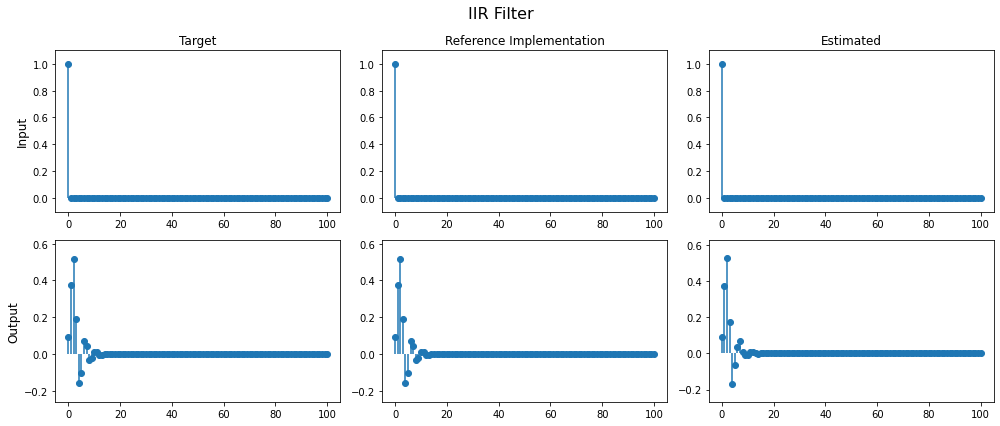

In [7]:
plot_loss(loss_history)
plot_params(params_target, params_history)
Y_reference = signal.lfilter(params_target['B'], params_target['A'], X)
plot_filter(X, Y_target, Y_reference, Y_estimated, 'IIR Filter')

In [8]:
%%time
X = np.random.uniform(-2, 2, X.size)
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train(Clip, X)

CPU times: user 7.14 s, sys: 240 ms, total: 7.38 s
Wall time: 7.21 s


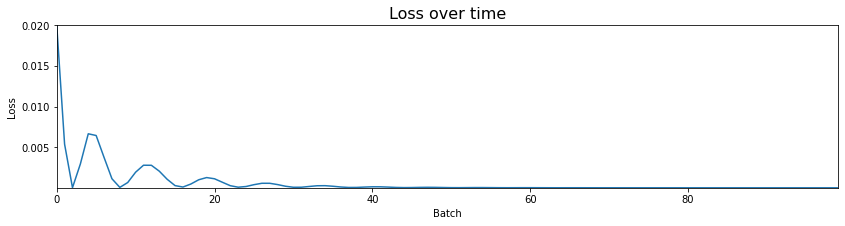

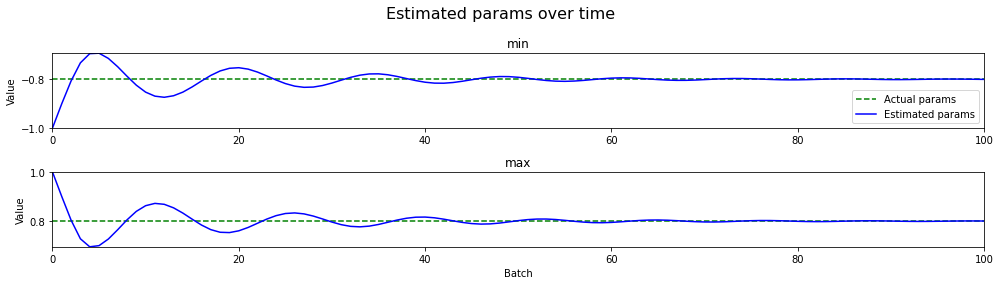

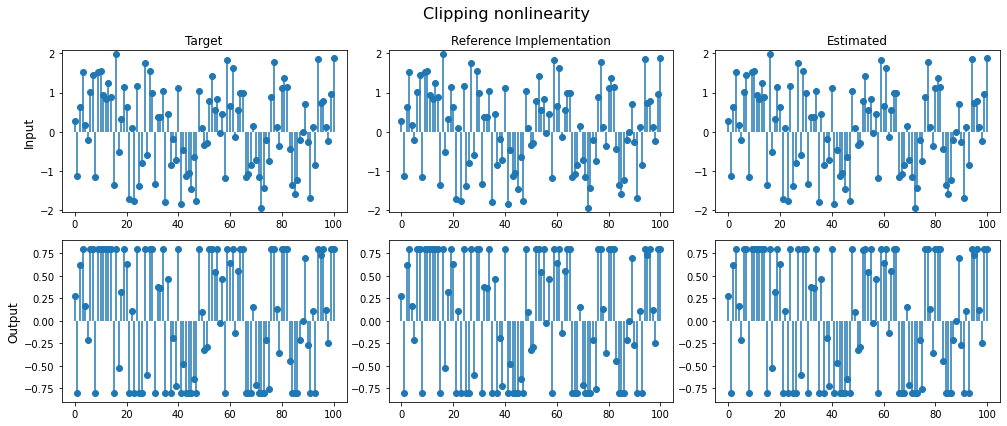

In [9]:
plot_loss(loss_history)
plot_params(params_target, params_history)
Y_reference = np.clip(X, params_target['min'], params_target['max'])
plot_filter(X, Y_target, Y_reference, Y_estimated, 'Clipping nonlinearity')

In [10]:
%%time
X = np.random.uniform(-2, 2, X.size)
params_estimated, params_target, Y_estimated, Y_target, params_history, loss_history = train_serial([IirFilter, Clip], X)

CPU times: user 1min 58s, sys: 1.94 s, total: 2min
Wall time: 2min


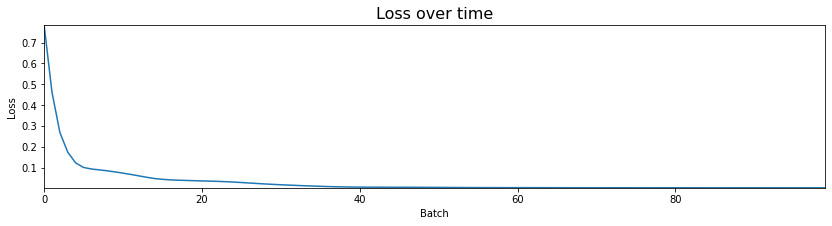

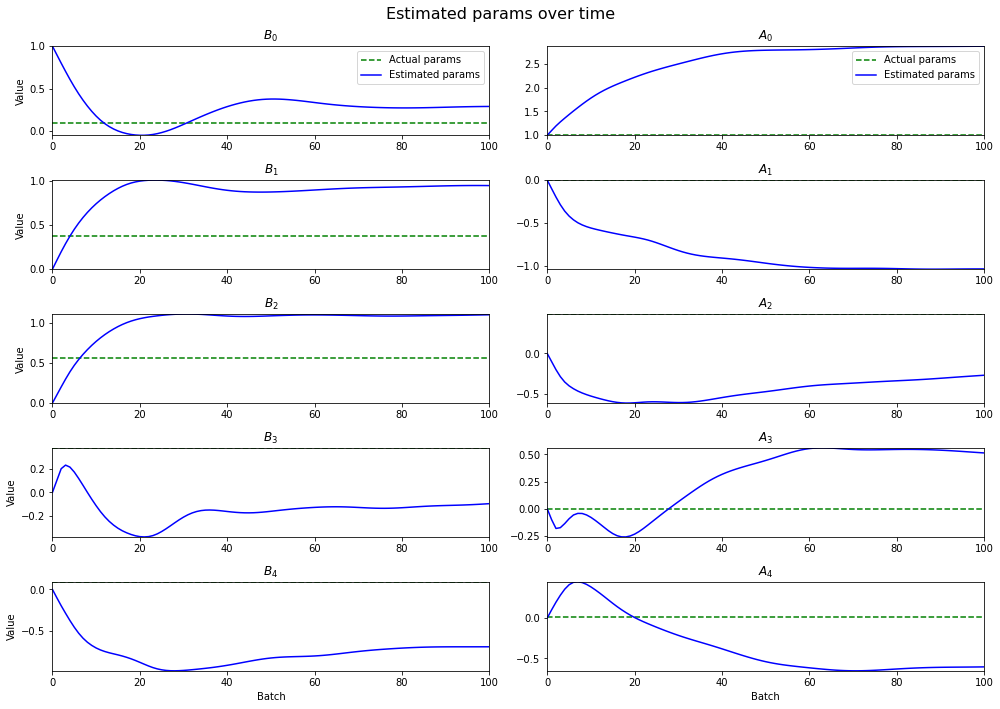

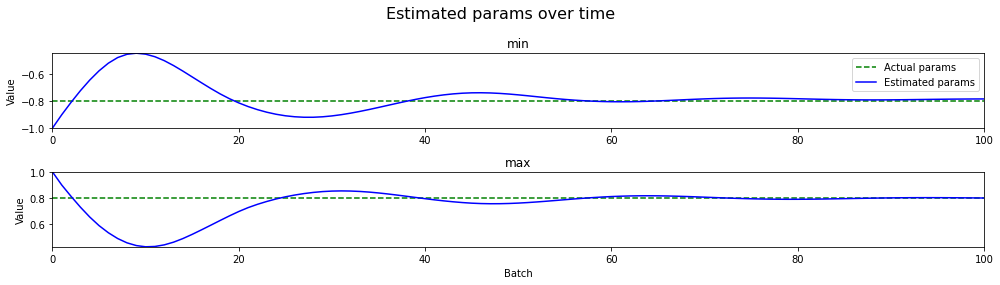

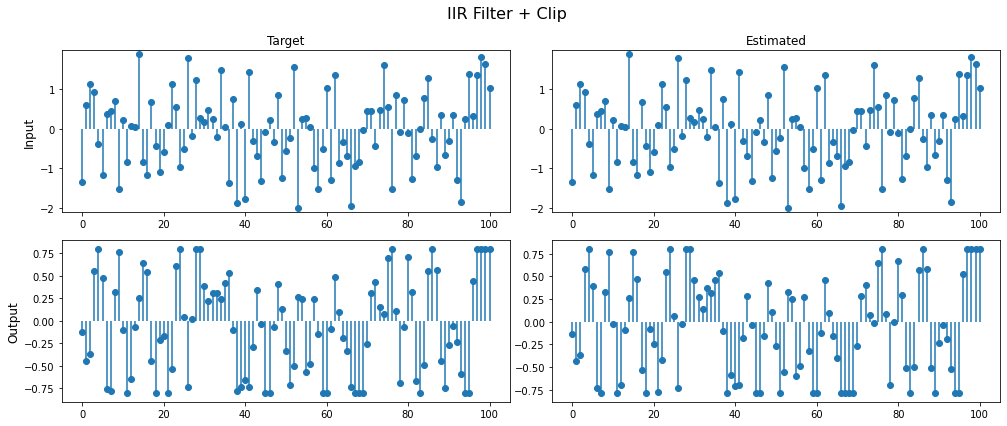

In [11]:
plot_loss(loss_history)
plot_params(params_target['iir_filter'], params_history['iir_filter'])
plot_params(params_target['clip'], params_history['clip'])

plot_filter(X, Y_target, None, Y_estimated, 'IIR Filter + Clip')

In [12]:
# import IPython
# from scipy.io.wavfile import read as wavread

# wav_fs, audio = wavread('speech-male.wav')
# audio = audio.astype(float) / audio.max()
# print('Original audio:')
# IPython.display.Audio(audio, rate=wav_fs)